In [2]:
import numpy as np, sympy, math
import scipy 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from qutip import *

In [3]:
class DensityMatrix:
    def __init__(self,rho):
        self.dim = rho.shape[0]
        self.rho = rho

    def __rmul__(self, scalar):
        if isinstance(scalar, (int,float,complex)):
            # Return a new DensityMatrix with the scaled matrix
            return DensityMatrix(self.rho * scalar)
        else:
            return NotImplemented

    def __sub__(self, dm):
        if isinstance(dm, DensityMatrix):
            return DensityMatrix(self.rho - dm.rho)
        else:
            return NotImplemented

    def __add__(self, dm):
        if isinstance(dm, DensityMatrix):
            return DensityMatrix(self.rho + dm.rho)
        else:
            return NotImplemented
            
    def __str__(self):
        return f"density matrix of dim {self.dim} with elements: \n {self.rho}"

class SystemRho(DensityMatrix):
    def __init__(self,init_rho):
        super().__init__(init_rho)
        dim = self.dim
        self.rhoS = np.zeros((dim,dim),dtype=object)
        self.vec_rhoS = np.zeros(dim**2,dtype=object)
        for i in range(dim):
            for j in range(dim):
                self.rhoS[i,j] = self.getElement(i,j)
                self.vec_rhoS[i*dim+j] = self.getElement(i,j)
                                               
                
                
    def getElement(self,r,c):
        rho_rc = sympy.symbols(f'rho{r}{c}')
        return rho_rc

    def getFlattened(self):
        return self.rho.flatten()



In [4]:
def partial_trace(op, bOps):
    rho = op.rho
    tSum = 0
    eye = np.identity(2)
    for i in bOps:
        vec1 = np.kron(eye,i.reshape(-1,1))
        vec2 = np.kron(eye, i)
        mod = np.dot(vec2, np.dot(rho, vec1))
        tSum += mod
    return DensityMatrix(tSum)

In [5]:
def get_JCH(t,omega,freq,rhoB,g): #Jaynes-Cummings model hamiltonian
    raising_op = create(2).full()
    lowering_op = destroy(2).full()
    B = sigmax().full()
    B_shift = g*bath_shift(B,rhoB)
    IP_Hamiltonian = 0j
    if isinstance(t,float):
        IP_Hamiltonian = np.kron(ip_op(lowering_op,t,omega),ip_op(B_shift,t,-freq)) + np.kron(ip_op(raising_op,t,-omega),ip_op(B_shift,t,freq))
    else:
        IP_Hamiltonian = np.kron(ip_op(lowering_op,t,omega),ip_op(B_shift,t,-freq)) + np.kron(ip_op(raising_op,t,-omega),ip_op(B_shift,t,freq))
    return IP_Hamiltonian

def bath_shift(B,rhoB):
    B_expect = np.trace(rhoB.rho * B)
    shifted_B = B - B_expect * np.identity(2)
    return shifted_B
    
def feshbach_proj(op,rhoB,Hb): #Projector onto space of valid initial conditions. Params = (rho, time-indep bath state, list of Hb eigenvectors (for ptrace)
    return DensityMatrix(np.kron(partial_trace(op,Hb).rho,rhoB.rho))

def L_op(H,op): #Liouville von Neumann eq. with factor of lambda. Params = (interaction hamiltonian Hsb, rho)
    return DensityMatrix(-1j *(np.dot(H,op.rho) - np.dot(op.rho,H)))

def ip_op(op,t,const): #interaction picture U on op; op is not a density matrix
    if isinstance(t,int):
        return np.round(np.exp(const*1j*t)*op,5)
    else:
        return sympy.nsimplify(sympy.exp(const*1j*t)*op,tolerance=1e-5)

def ip_op_mat(op,t,Hs):
    mat_Hs = sympy.Matrix(-1j*t*Hs)
    exp_Hs = sympy.nsimplify(mat_Hs.exp(),tolerance=1e-5)
    exp = np.array(exp_Hs).astype(object)
    exp_dag = np.conj(exp).T
    result = exp_dag @ op.rho @ exp
    return DensityMatrix(result)

def integrate_dm(op,t,t_p):
    dm = op.rho
    dim = op.dim
    int_mat = np.zeros((dim,dim),dtype=object)
    for row in range(op.dim):
        for col in range(op.dim):
            int_mat[row,col] = sympy.integrate(sympy.nsimplify(dm[row,col],tolerance = 1e-10),(t_p,0,t))
    return DensityMatrix(int_mat)

def analyticalFunction(t,lam,tauB,g0):
    strength = 1-2*lam**2*g0*tauB

    s = np.sqrt(complex(strength))
    rho11 = 0
    if strength > 0:
        rho11 = math.exp(-t/tauB) * abs((math.cosh(t*s/(2*tauB)))+(1/s)*math.sinh(t*s/(2*tauB)))**2
    else:
        rho11 = math.exp(-t/tauB) * abs(math.cos(t*abs(s)/(2*tauB))+(1/((1j)*abs(s)))*math.sin(t*abs(s)/(2*tauB)))**2
        
    return rho11

def actual(t,lam,tauB,g0,order):
    #if order == 2:
      #  return g0 * lam**2*(1-math.exp(-t/tauB))
    #elif order == 4:
    #    return g0 * lam**2*(1-math.exp(-t/tauB)) + 1/tauB*(math.sinh(t/tauB) - t/tauB) * math.exp(-t/tauB)
    return math.exp(-g0*t)
        
def plot_result(title,sol,row,col,t,lam,tauB,g0):
    #Analytical for comparison
    
    dim = int(math.sqrt(sol.y.shape[0]))
    idx = row*dim+col
    tArr = []
    analyticalPopArr = []
    o2Arr = []
    o4Arr = []
    xScale = 0.01
    for i in range(int(t/xScale)):
        tArr.append(i*xScale*g0)
        analyticalPopArr.append(analyticalFunction(i*xScale,lam,tauB,g0))
        o2Arr.append(actual(i*xScale,lam,tauB,g0,2))
        o4Arr.append(actual(i*xScale,lam,tauB,g0,4))
    plt.clf()
    
    plt.plot(tArr, analyticalPopArr,label='Analytic')
    plt.plot(tArr, o2Arr,label='TCL2')
    #plt.plot(tArr, o4Arr,label='TCL4')

    
    dim = int(math.sqrt(sol.y.shape[0]))
    idx = row*dim+col
    plt.plot(sol.t*g0, sol.y[idx], label=f'rho{row}{col}(t)')
    plt.xlabel('t*g0')
    plt.ylabel('rho')
    plt.title(title)
    plt.xlim(left=0)   
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()
    '''
    # test:
    dim = int(math.sqrt(sol.y.shape[0]))
    idx = row*dim+col
    specific_time = 5.5
    interpolated_solution = np.interp(specific_time, sol.t, sol.y[idx])
    if (interpolated_solution != 1):'''

def plot_all_results(sol):
    plt.clf()
    plt.xlabel('t')
    plt.ylabel('rho')
    plt.title('Redfield sol')
    dim = int(math.sqrt(sol.y.shape[0]))
    for row in range(dim):
        for col in range(dim):
            idx = row*dim+col
            plt.plot(sol.t, sol.y[idx], label=f'rho{row}{col}(t)')
    plt.xlim(left=0)     
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()




    

In [6]:
def Redfield_eq(t,rho_t,Hb,rhoB,rho_s0,omega,freq,lam,g):
    HamS = omega*operators.num(2).full()
    HamB = omega*qeye(2).full()

    t_deq = sympy.symbols('t_deq')
    rho_ip = ip_op_mat(rho_t,t_deq,HamS)
    rhoB_ip = ip_op_mat(rhoB,t_deq,HamB)
    
    init_state = DensityMatrix(np.kron(rho_ip.rho,rhoB_ip.rho))
    t_prime = sympy.symbols('t_prime')
    inner_op = lam**2*feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb)
    sys = partial_trace(inner_op,Hb)
    int_sys = integrate_dm(sys,t_deq,t_prime)
    sol = parse_and_solve(int_sys,rho_s0,t)
    
    return sol

In [7]:
def TCL4_eq(t,rho_t,Hb,rhoB,rho_s0,omega,freq,lam,g): 
    HamS = omega*operators.num(2).full()
    HamB = omega*qeye(2).full()
    
    t_deq = sympy.symbols('t_deq')
    rho_ip = ip_op_mat(rho_t,t_deq,HamS)
    rhoB_ip = ip_op_mat(rhoB,t_deq,HamB)

    #Redfield part
    init_state = DensityMatrix(np.kron(rho_ip.rho,rhoB_ip.rho))
    t_prime = sympy.symbols('t_prime')
    inner_op = lam**2*feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb)
    sys = partial_trace(inner_op,Hb)
    int_sys = integrate_dm(sys,t_deq,t_prime)

    ##TCL4 part
    t_d_prime = sympy.symbols('t_double_prime')
    t_t_prime = sympy.symbols('t_triple_prime')
    op1 = feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_d_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_t_prime,omega,freq,rhoB_ip,g),init_state)))),rhoB_ip,Hb)
    op2 = feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),feshbach_proj(L_op(get_JCH(t_d_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_t_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb))),rhoB_ip,Hb)
    op3 = feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_d_prime,omega,freq,rhoB_ip,g),feshbach_proj(L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_t_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb))),rhoB_ip,Hb)
    op4 = feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_t_prime,omega,freq,rhoB_ip,g),feshbach_proj(L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_d_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb))),rhoB_ip,Hb)

    print('integrating...')
    total_op = lam**4 * (op1-op2-op3-op4)
    sys4 = partial_trace(total_op,Hb)
    int1 = integrate_dm(sys4,t_d_prime,t_t_prime)
    int2 = integrate_dm(int1,t_prime,t_d_prime)
    int3 = integrate_dm(int2,t_deq,t_prime)
    full_sys = int_sys + int3

    print('solving...')
    sol = parse_and_solve(full_sys,rho_s0,t)
    return sol
    

In [8]:
#For adjoints
def P_adj(op,rhoB,Hb): #Projector onto space of valid initial conditions. Params = (rho, time-indep bath state, list of Hb eigenvectors (for ptrace)
    ident = np.identity(2)
    trace_mult = DensityMatrix(op.rho @ np.kron(ident,rhoB.rho))
    return DensityMatrix(np.kron(partial_trace(trace_mult,Hb).rho,ident))

def L_adj(H,op): #adjoint of L_op
    return DensityMatrix(1j *(np.dot(H,op.rho) - np.dot(op.rho,H)))


In [9]:
def TCLPLUS5_eq(t,rho_t,Hb,rhoB,rho_s0,omega,freq,lam,g): 
    HamS = omega*operators.num(2).full()
    HamB = g*sigmax().full()
    
    t_deq = sympy.symbols('t_deq')
    rho_ip = ip_op_mat(rho_t,t_deq,HamS)
    rhoB_ip = ip_op_mat(rhoB,t_deq,HamB)
    
    init_state = DensityMatrix(np.kron(rho_ip.rho,rhoB_ip.rho))
    
    ##Redfield part
    t_prime = sympy.symbols('t_prime')
    inner_op = lam**2*feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb)
    sys = partial_trace(inner_op,Hb)
    int_sys = integrate_dm(sys,t_deq,t_prime)

    ##TCL4 part
    t_d_prime = sympy.symbols('t_double_prime')
    t_t_prime = sympy.symbols('t_triple_prime')
    op1 = feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_d_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_t_prime,omega,freq,rhoB_ip,g),init_state)))),rhoB_ip,Hb)
    op2 = feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),feshbach_proj(L_op(get_JCH(t_d_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_t_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb))),rhoB_ip,Hb)
    op3 = feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_d_prime,omega,freq,rhoB_ip,g),feshbach_proj(L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_t_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb))),rhoB_ip,Hb)
    op4 = feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),L_op(get_JCH(t_t_prime,omega,freq,rhoB_ip,g),feshbach_proj(L_op(get_JCH(t_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_d_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb))),rhoB_ip,Hb)

    total_op = lam**4 * (op1-op2-op3-op4)
    sys4 = partial_trace(total_op,Hb)
    int1 = integrate_dm(sys4,t_d_prime,t_t_prime)
    int2 = integrate_dm(int1,t_prime,t_d_prime)
    int3 = integrate_dm(int2,t_deq,t_prime)
    
    ##New TCL+-5 Part
    t_q_prime = sympy.symbols('t_quadruple_prime')
    plus_op1 = feshbach_proj(L_op(get_JCH(t_d_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_q_prime,omega,freq,rhoB_ip,g),init_state)),rhoB_ip,Hb)
    plus_op2 = P_adj(L_adj(get_JCH(t_prime,omega,freq,rhoB_ip,g),L_op(get_JCH(t_t_prime,omega,freq,rhoB_ip,g),plus_op1)),rhoB_ip,Hb)
    plus_op3 = 2*lam**5*feshbach_proj(L_op(get_JCH(t_deq,omega,freq,rhoB_ip,g),plus_op2),rhoB_ip,Hb)
    
    print('integrating +5')
    
    sysplus = partial_trace(plus_op3,Hb)
    pint1 = integrate_dm(sysplus,t_deq,t_q_prime)
    pint2 = integrate_dm(pint1,t_d_prime,t_t_prime)
    pint3 = integrate_dm(pint2,t_deq,t_d_prime)
    pint4 = integrate_dm(pint3,t_deq,t_prime)
    full_sys = pint4 +int_sys+int3

    print('solving +5')
    sol = parse_and_solve(full_sys,rho_s0,t)
    return sol

    

In [10]:
def parse_and_solve(op,s_op,time):
    dm = op.rho
    dim = op.dim
    def super_dm_matrix(t):
        super_dm_mat = np.zeros((dim**2,dim**2),dtype=object)
        for row in range(dim):
            for col in range(dim):
                for index,element in enumerate(s_op.vec_rhoS):
                    factor = sympy.expand(dm[row,col]).coeff(element)
                    factor_j = factor.subs(sympy.I, 1j)
                    factor_t = factor_j.subs(sympy.symbols('t_deq'),t)
                    super_dm_mat[row*dim+col,index] = factor_t
        return super_dm_mat
    #solving
    t_span = (0,time)
    y0 = s_op.getFlattened().astype(np.complex128)
    
    def system(t,y):
        sdm = super_dm_matrix(t)
        return np.dot(sdm,y)
    sol = solve_ivp(system,t_span,y0,max_step = 0.5,atol = 1e-5,rtol=1e-2)
    return sol

In [14]:
def JaynesCummingsModel(initconds,strength):
    rhoS0 = SystemRho(initconds)
    rhoB = DensityMatrix(np.array([[1,1],[1,0]]))
    
    bOps = [np.array([1,0]),np.array([0,0])]
    
    omega = 1 #excited state energy
    freq = 1 #bath mode k frequency
    lam = 1 #coupling const
    tauB = 1
    gamma0 = 0
    time = 0
    if strength == 0: #weak coupling
        gamma0 = 0.2*1/(tauB)
        time = 40
    else: #strong coupling
        gamma0 = 5*1/(tauB)
        time = 5
    g = np.sqrt(gamma0/(tauB * 2*math.pi))
    
    
    rhos_t = DensityMatrix(rhoS0.rhoS)
    
    
    #interaction picture
    
    redfield_sol = Redfield_eq(time,rhos_t,bOps,rhoB,rhoS0,omega,freq,lam,g) 
    plot_result('Redfield sol',redfield_sol,1,1,time,lam,tauB,gamma0)
    
    tcl_sol = TCL4_eq(time,rhos_t,bOps,rhoB,rhoS0,omega,freq,lam,g) 
    print("plotting...")
    plot_result('TCL4 sol',tcl_sol,1,1,time,lam,tauB,gamma0)
    '''
    plus_sol = TCLPLUS5_eq(time,rhos_t,bOps,rhoB,rhoS0,omega,freq,lam,g) 
    print('plotting')
    plot_result('TCL+5 sol',plus_sol,1,1,time,lam,tauB,gamma0)
    '''


C:\Users\cblum\AppData\Local\Temp\ipykernel_1928\720195559.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  rho11 = math.exp(-t/tauB) * abs((math.cosh(t*s/(2*tauB)))+(1/s)*math.sinh(t*s/(2*tauB)))**2
C:\Users\cblum\conda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\cblum\conda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


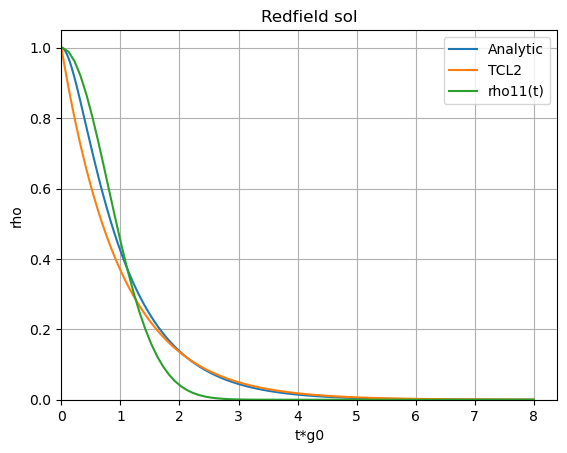

integrating...
solving...
plotting...


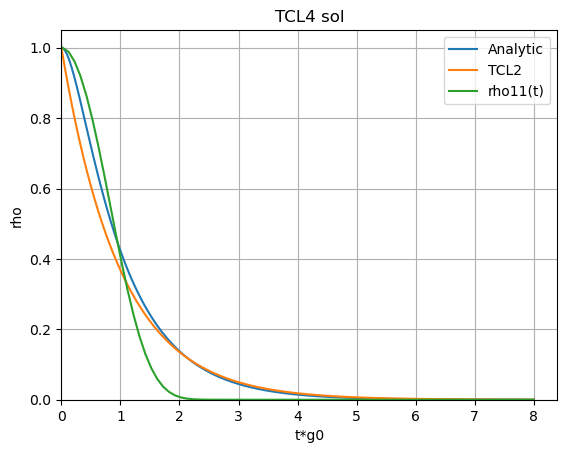

CPU times: total: 16.3 s
Wall time: 49.7 s


In [12]:
%%time
init_conds = np.array([[0,0],[0,1]])
JaynesCummingsModel(init_conds,0)

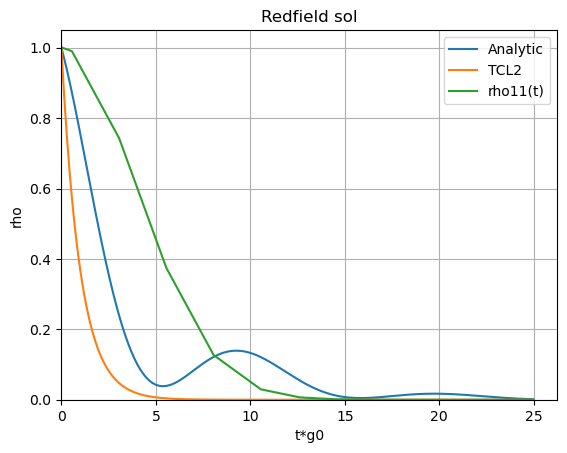

integrating...
solving...
plotting...


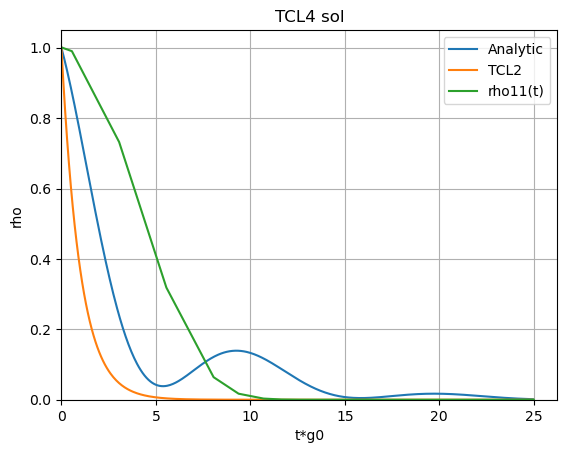

CPU times: total: 7.5 s
Wall time: 16.5 s


In [15]:
%%time
init_conds = np.array([[0,0],[0,1]])
JaynesCummingsModel(init_conds,1)